# Data Analysis & Web Scraping Overview

We begin by web scraping operational data from [Nexo Pizza Hack-n-Slice 2025](https://nexopizza.github.io/hack-n-slice-constantine-2025/). The extracted data is cleaned and saved as `daily_context.csv` for downstream forecasting and analysis.


In [ ]:
import requests
from bs4 import BeautifulSoup

base_url = "https://nexopizza.github.io/hack-n-slice-constantine-2025/"
index_page = requests.get(base_url)
soup = BeautifulSoup(index_page.content, "html.parser")

# Extract all date links
date_links = [a['href'] for a in soup.select("a.date")]

import pandas as pd

records = []

for link in date_links:
    url = base_url + link
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    
    date = link.replace(".html", "")
    city = soup.select_one("header .muted")
    city = city.text.strip() if city else "Unknown"

    # Weather
    weather_section = soup.select_one("section.weather")
    weather_data = {
        "weather_desc": None,
        "temp_min_c": None,
        "temp_max_c": None,
        "humidity_pct": None,
        "wind_kph": None,
        "precip_mm": None,
        "precip_prob": None,
        "alerts": None
    }

    if weather_section and weather_section.find("table"):
        for row in weather_section.select("table tr"):
            label = row.find("th").text.strip()
            value_cell = row.find("td")
            if "Temp min/max" in label:
                temps = value_cell.text.strip().split("/")
                weather_data["temp_min_c"] = float(temps[0])
                weather_data["temp_max_c"] = float(temps[1])
            elif "Description" in label:
                weather_data["weather_desc"] = value_cell.text.strip()
            elif "Humidity" in label:
                weather_data["humidity_pct"] = int(value_cell.text.strip())
            elif "Wind" in label:
                weather_data["wind_kph"] = int(value_cell.text.strip())
            elif "Precip (mm)" in label:
                weather_data["precip_mm"] = float(value_cell.text.strip())
            elif "Precip prob" in label:
                weather_data["precip_prob"] = float(value_cell.text.strip())
            elif "Alerts" in label:
                weather_data["alerts"] = value_cell.text.strip()

    # Events
    events = []
    event_rows = soup.select("section.events table tbody tr")
    for row in event_rows:
        event = {
            "start_time_local": row.select_one(".start_time_local").text.strip() if row.select_one(".start_time_local") else None,
            "event_type": row.select_one(".event_type").text.strip(),
            "title": row.select_one(".title").text.strip(),
            "description": row.select_one(".description").text.strip(),
            "channel_focus": row.select_one(".channel_focus").text.strip(),
            "tags": row.select_one(".tags").text.strip()
        }
        events.append(event)

    records.append({
        "date": date,
        "city": city,
        **weather_data,
        "events": events
    })

df = pd.DataFrame(records)
df.to_csv("daily_context.csv", index=False)


##  `items.ndjson` — Product Catalog Overview

In [3]:
import pandas as pd

items = pd.read_json("items.ndjson", lines=True)
items.head()


,_id,name,category,workflow,basePrice,hasSize,hasToppings
0,68b35fc2868d406af5688772,Pizza Margherita,Pizzas,PIZZA,350,False,True
1,68b35fc2868d406af5688794,Pizza 3 Fromages,Pizzas,PIZZA,500,False,True
2,68b35fc2868d406af56887b5,Pizza Végétarienne,Pizzas,PIZZA,350,False,True
3,68b35fc2868d406af56887d6,Pizza Végétarienne Champignions,Pizzas,PIZZA,450,False,True
4,68b35fc2868d406af56887f7,Pizza Légumes Poulet,Pizzas,PIZZA,500,False,True


In [4]:
items.info()
items.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _id          51 non-null     object
 1   name         51 non-null     object
 2   category     51 non-null     object
 3   workflow     51 non-null     object
 4   basePrice    51 non-null     int64 
 5   hasSize      51 non-null     bool  
 6   hasToppings  51 non-null     bool  
dtypes: bool(2), int64(1), object(4)
memory usage: 2.2+ KB


,_id,name,category,workflow,basePrice,hasSize,hasToppings
count,51,51,51,51,51.000000,51,51
unique,51,51,8,3,NaN,2,2
top,68b35fc2868d406af5688772,Pizza Margherita,Pizzas,BAR,NaN,False,False
freq,1,1,16,18,NaN,47,32
mean,NaN,NaN,NaN,NaN,266.862745,NaN,NaN
std,NaN,NaN,NaN,NaN,213.817588,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,60.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,250.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,425.000000,NaN,NaN


In [5]:
# Check for missing values
items.isnull().sum()

# Check for duplicate IDs
items['_id'].duplicated().sum()

# Check for negative or zero prices
items[items['basePrice'] <= 0]

# Check category and workflow consistency
items['category'].value_counts()
items['workflow'].value_counts()


workflow
BAR      18
OTHER    17
PIZZA    16
Name: count, dtype: int64

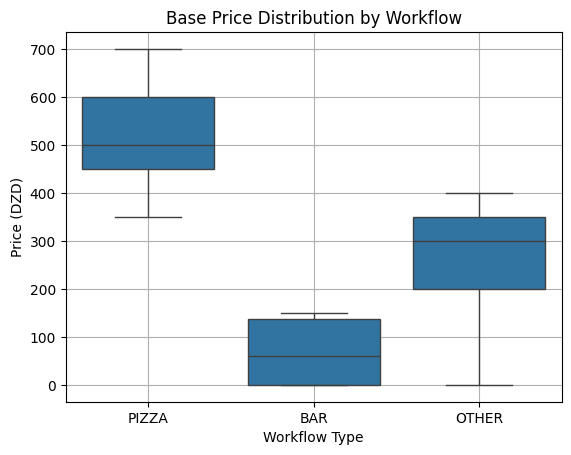

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=items, x='workflow', y='basePrice')
plt.title("Base Price Distribution by Workflow")
plt.ylabel("Price (DZD)")
plt.xlabel("Workflow Type")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


###  Schema Summary

| Column        | Type    | Description                                                                 |
|---------------|---------|------------------------------------------------------------------------------|
| `_id`         | string  | Unique identifier for each product                                           |
| `name`        | string  | Product name (e.g., "Pizza Margherita")                                     |
| `category`    | string  | Product category (e.g., "Pizzas", "Drinks")                                 |
| `workflow`    | string  | Operational workflow (e.g., "PIZZA", "BAR", "OTHER")                        |
| `basePrice`   | int     | Base price in DZD (e.g., 600 = 600 DZD)                                     |
| `hasSize`     | bool    | Indicates if the item supports size options                                 |
| `hasToppings` | bool    | Indicates if the item supports topping options                              |

---

#### Key Observations

- **Total Items**: 51
- **Unique Categories**: 8
- **Workflow Distribution**:
  - `BAR`: 18 items
  - `OTHER`: 17 items
  - `PIZZA`: 16 items
- **Price Range**: 0 to 700 DZD
  - Mean price: ~267 DZD
  - Items with `basePrice = 0` may be modifiers or mispriced
- **Customization Flags**:
  - `hasSize`: Mostly `False` (47/51)
  - `hasToppings`: Mostly `True` for pizzas (32/51)

---

##  `options.ndjson` — Modifier Catalog Overview


In [7]:
options = pd.read_json("options.ndjson", lines=True)
options.head()


,_id,kind,name,priceDelta,itemScope
0,68b35fc2868d406af5688773,SAUCE,Sauce Tomate,0,[68b35fc2868d406af5688772]
1,68b35fc2868d406af5688774,SAUCE,Sauce Crème,0,[68b35fc2868d406af5688772]
2,68b35fc2868d406af5688775,TOPPING,Bordure Traditionnelle,0,[68b35fc2868d406af5688772]
3,68b35fc2868d406af5688776,TOPPING,Bordure Fine,0,[68b35fc2868d406af5688772]
4,68b35fc2868d406af5688777,EDGE,Pâte S,0,[68b35fc2868d406af5688772]


In [8]:
options.info()
options.describe(include='all')

# Check for missing values
options.isnull().sum()

# Check for duplicate IDs
options['_id'].duplicated().sum()

# Unique modifier types
options['kind'].value_counts()

# Check if all itemScope references exist in items
valid_item_ids = set(items['_id'])
options['valid_scope'] = options['itemScope'].apply(lambda scope: all(i in valid_item_ids for i in scope))
options['valid_scope'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         641 non-null    object
 1   kind        641 non-null    object
 2   name        641 non-null    object
 3   priceDelta  641 non-null    int64 
 4   itemScope   641 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.2+ KB


valid_scope
True    641
Name: count, dtype: int64

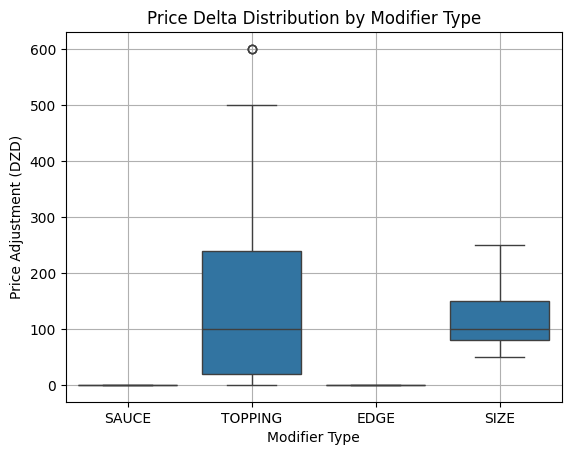

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=options, x='kind', y='priceDelta')
plt.title("Price Delta Distribution by Modifier Type")
plt.ylabel("Price Adjustment (DZD)")
plt.xlabel("Modifier Type")
plt.grid(True)
plt.show()


###  Schema Summary

| Column       | Type    | Description                                                                 |
|--------------|---------|------------------------------------------------------------------------------|
| `_id`        | string  | Unique identifier for each modifier                                          |
| `kind`       | string  | Modifier type: `SAUCE`, `TOPPING`, `EDGE`, or `SIZE`                         |
| `name`       | string  | Modifier label (e.g., "Sauce Tomate", "Bordure Fine")                        |
| `priceDelta` | int     | Price adjustment in DZD (e.g., 100 = +100 DZD, 0 = no change)                |
| `itemScope`  | list    | List of item `_id`s this modifier applies to                                |

---

###  Key Observations

- **Total Modifiers**: 641
- **Modifier Types**:
  - `TOPPING`: Most frequent
  - `SAUCE`, `EDGE`, `SIZE`: Also present
- **Price Delta Distribution**:
  - Many modifiers have `priceDelta = 0` (e.g., sauces, edges)
  - `TOPPING` and `SIZE` show wider price variation
- **Scope Validation**:
  - All `itemScope` references are valid (100% match with `items._id`)

---


##  `orders.ndjson` — Order Header Overview


In [10]:
options = pd.read_json("options.ndjson", lines=True)
options.head()


,_id,kind,name,priceDelta,itemScope
0,68b35fc2868d406af5688773,SAUCE,Sauce Tomate,0,[68b35fc2868d406af5688772]
1,68b35fc2868d406af5688774,SAUCE,Sauce Crème,0,[68b35fc2868d406af5688772]
2,68b35fc2868d406af5688775,TOPPING,Bordure Traditionnelle,0,[68b35fc2868d406af5688772]
3,68b35fc2868d406af5688776,TOPPING,Bordure Fine,0,[68b35fc2868d406af5688772]
4,68b35fc2868d406af5688777,EDGE,Pâte S,0,[68b35fc2868d406af5688772]


In [11]:
options.info()
options.describe(include='all')

# Check for missing values
options.isnull().sum()

# Check for duplicate IDs
options['_id'].duplicated().sum()

# Unique modifier types
options['kind'].value_counts()

# Check if all itemScope references exist in items
valid_item_ids = set(items['_id'])
options['valid_scope'] = options['itemScope'].apply(lambda scope: all(i in valid_item_ids for i in scope))
options['valid_scope'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   _id         641 non-null    object
 1   kind        641 non-null    object
 2   name        641 non-null    object
 3   priceDelta  641 non-null    int64 
 4   itemScope   641 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.2+ KB


valid_scope
True    641
Name: count, dtype: int64

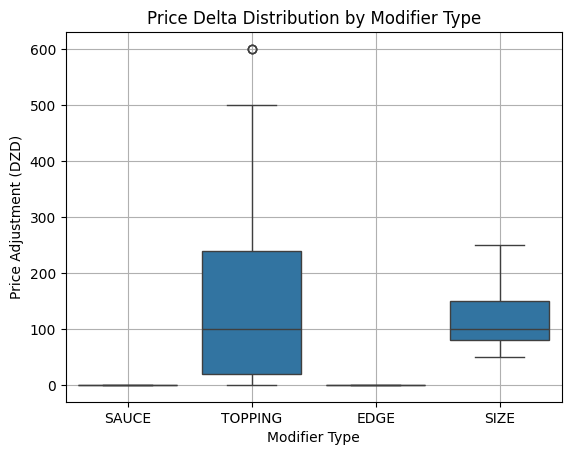

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=options, x='kind', y='priceDelta')
plt.title("Price Delta Distribution by Modifier Type")
plt.ylabel("Price Adjustment (DZD)")
plt.xlabel("Modifier Type")
plt.grid(True)
plt.show()


###  Schema Summary

| Column       | Type    | Description                                                                 |
|--------------|---------|------------------------------------------------------------------------------|
| `_id`        | string  | Unique identifier for each modifier                                          |
| `kind`       | string  | Modifier type: `SAUCE`, `TOPPING`, `EDGE`, or `SIZE`                         |
| `name`       | string  | Modifier label (e.g., "Sauce Tomate", "Bordure Fine")                        |
| `priceDelta` | int     | Price adjustment in DZD (e.g., 100 = +100 DZD, 0 = no change)                |
| `itemScope`  | list    | List of item `_id`s this modifier applies to                                |

---

###  Key Observations

- **Total Modifiers**: 641
- **Modifier Types**:
  - `TOPPING`: Most frequent
  - `SAUCE`, `EDGE`, `SIZE`: Also present
- **Price Delta Distribution**:
  - Many modifiers have `priceDelta = 0` (e.g., sauces, edges)
  - `TOPPING` and `SIZE` show wider price variation
- **Scope Validation**:
  - All `itemScope` references are valid (100% match with `items._id`)

---


##  `orders.ndjson` — Order Header Overview


In [13]:
orders = pd.read_json("orders.ndjson", lines=True)
orders.head()


,_id,storeId,source,status,createdAt
0,68b35fc2868d406af5688c70,68b35fc2868d406af5688771,pos,DELIVERED,2020-08-28T12:13:40.544Z
1,68b35fc2868d406af5688c75,68b35fc2868d406af5688771,pos,DELIVERED,2020-08-28T11:45:35.401Z
2,68b35fc2868d406af5688c7b,68b35fc2868d406af5688771,delivery,DELIVERED,2020-08-28T12:14:39.178Z
3,68b35fc2868d406af5688c80,68b35fc2868d406af5688771,delivery,DELIVERED,2020-08-28T11:51:22.751Z
4,68b35fc2868d406af5688c88,68b35fc2868d406af5688771,pos,DELIVERED,2020-08-28T11:44:48.931Z


In [14]:
orders.info()
orders.describe(include='all')

# Convert timestamp
orders['createdAt'] = pd.to_datetime(orders['createdAt'])

# Check for missing values
orders.isnull().sum()

# Filter valid orders
valid_orders = orders[orders['status'] == 'DELIVERED']

# Check source distribution
valid_orders['source'].value_counts()

# Check date range
valid_orders['createdAt'].agg(['min', 'max'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263775 entries, 0 to 263774
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   _id        263775 non-null  object
 1   storeId    263775 non-null  object
 2   source     263775 non-null  object
 3   status     263775 non-null  object
 4   createdAt  263775 non-null  object
dtypes: object(5)
memory usage: 10.1+ MB


min   2020-08-28 11:00:25.479000+00:00
max   2025-08-28 21:49:19.117000+00:00
Name: createdAt, dtype: datetime64[ns, UTC]

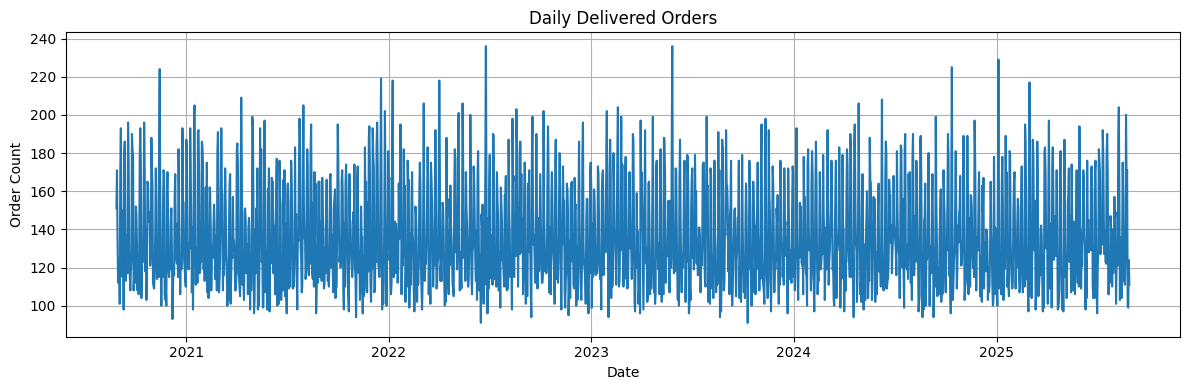

In [15]:
import matplotlib.pyplot as plt

daily_orders = valid_orders.groupby(valid_orders['createdAt'].dt.date).size()
daily_orders.plot(figsize=(12, 4), title="Daily Delivered Orders")
plt.ylabel("Order Count")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


###  Schema Summary

| Column      | Type    | Description                                                                 |
|-------------|---------|------------------------------------------------------------------------------|
| `_id`       | string  | Unique identifier for each order                                             |
| `storeId`   | string  | Store identifier (single store in this dataset)                              |
| `source`    | string  | Order source: `pos`, `delivery`, or `online`                                 |
| `status`    | string  | Order status: `DELIVERED`, `CANCELLED`, `REJECTED`, `IN_PROGRESS`            |
| `createdAt` | datetime| Timestamp of order creation (ISO format)                                     |

---

###  Key Observations

- **Total Orders**: 263,775
- **Date Range**: August 28, 2020 → August 28, 2025
- **Order Status**:
  - Only `DELIVERED` orders are used for forecasting
- **Source Distribution**:
  - Includes `pos` and `delivery` (others may be present)
- **Timestamp Format**:
  - Converted to UTC-aware datetime for time series analysis

---

##  `order_items.ndjson` — Line-Level Order Details


In [16]:
order_items = pd.read_json("order_items.ndjson", lines=True)
order_items.head()


,_id,orderId,lineNo,itemId,qty,unitPrice,appliedOptions
0,68b35fc2868d406af5688c71,68b35fc2868d406af5688c70,1,68b35fc2868d406af5688902,2,600,"[68b35fc2868d406af5688903, 68b35fc2868d406af56..."
1,68b35fc2868d406af5688c73,68b35fc2868d406af5688c70,2,68b35fc2868d406af56887f7,2,500,[68b35fc2868d406af56887f9]
2,68b35fc2868d406af5688c76,68b35fc2868d406af5688c75,1,68b35fc2868d406af5688944,2,500,[68b35fc2868d406af5688945]
3,68b35fc2868d406af5688c78,68b35fc2868d406af5688c75,2,68b35fc2868d406af56887f7,1,500,"[68b35fc2868d406af56887f8, 68b35fc2868d406af56..."
4,68b35fc2868d406af5688c7c,68b35fc2868d406af5688c7b,1,68b35fc2868d406af56887f7,1,500,"[68b35fc2868d406af56887f9, 68b35fc2868d406af56..."


In [17]:
order_items.info()
order_items.describe()

# Check for missing values
order_items.isnull().sum()

# Check for duplicate line IDs
order_items['_id'].duplicated().sum()

# Validate references
valid_order_ids = set(orders['_id'])
valid_item_ids = set(items['_id'])

order_items['valid_order'] = order_items['orderId'].isin(valid_order_ids)
order_items['valid_item'] = order_items['itemId'].isin(valid_item_ids)

order_items[['valid_order', 'valid_item']].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527243 entries, 0 to 527242
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             527243 non-null  object
 1   orderId         527243 non-null  object
 2   lineNo          527243 non-null  int64 
 3   itemId          527243 non-null  object
 4   qty             527243 non-null  int64 
 5   unitPrice       527243 non-null  int64 
 6   appliedOptions  527243 non-null  object
dtypes: int64(3), object(4)
memory usage: 28.2+ MB


valid_order  valid_item
True         True          527243
Name: count, dtype: int64

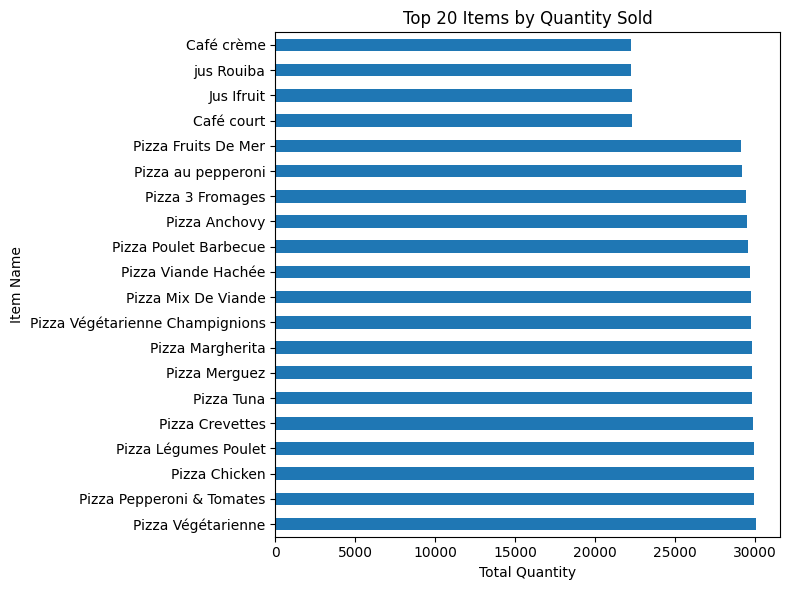

In [18]:
# Merge with item names
item_lookup = items[['_id', 'name']].rename(columns={'_id': 'itemId'})
order_items_named = order_items.merge(item_lookup, on='itemId')

# Aggregate quantities by item name
top_named_items = (
    order_items_named.groupby('name')['qty']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

# Plot
top_named_items.plot(kind='barh', figsize=(8, 6), title="Top 20 Items by Quantity Sold")
plt.xlabel("Total Quantity")
plt.ylabel("Item Name")
plt.tight_layout()
plt.show()

###  Schema Summary

| Column          | Type    | Description                                                                 |
|-----------------|---------|------------------------------------------------------------------------------|
| `_id`           | string  | Unique identifier for each line item                                         |
| `orderId`       | string  | Reference to the parent order                                                |
| `lineNo`        | int     | Line number within the order                                                 |
| `itemId`        | string  | Reference to the product ordered                                             |
| `qty`           | int     | Quantity of the item ordered                                                 |
| `unitPrice`     | int     | Price per unit in DZD                                                        |
| `appliedOptions`| list    | List of modifier IDs applied to the item                                     |

---

###  Key Observations

- **Total Line Items**: 527,243
- **Data Integrity**:
  - All `orderId` and `itemId` references are valid
  - No missing values or duplicate `_id`s
- **Quantity Distribution**:
  - Most items ordered in quantities of 1–2
  - High-volume items are primarily pizzas
- **Modifier Usage**:
  - `appliedOptions` contains multiple IDs per item, indicating customization
  - Can be joined with `options.ndjson` to calculate adjusted prices

---

###  Interpretation

- **Pizza Dominance**:  
  The top-selling items are all pizza variants, indicating strong customer preference and operational focus on the PIZZA workflow.

- **Balanced Demand**:  
  Quantities across top items are relatively uniform, suggesting menu design encourages variety without skewing demand.

- **Low Beverage Volume**:  
  Items like *Café crème* and *Jus Rouiba* appear less frequently, which may reflect secondary purchase behavior or limited promotion.
  
---


##  `restocks.ndjson` — Ingredient Replenishment Events


In [19]:
restocks = pd.read_json("restocks.ndjson", lines=True)
restocks.head()


,_id,stockItemId,storeId,initialQty,unit,ttlSec,createdAt
0,68b35fc2868d406af5688a94,68b35fc2868d406af5688a26,68b35fc2868d406af5688771,11310,ml,691200,2025-08-08T02:26:50.191Z
1,68b35fc2868d406af5688a95,68b35fc2868d406af5688a26,68b35fc2868d406af5688771,8147,ml,691200,2025-08-26T21:26:44.535Z
2,68b35fc2868d406af5688a96,68b35fc2868d406af5688a26,68b35fc2868d406af5688771,7461,ml,691200,2025-08-06T18:43:00.305Z
3,68b35fc2868d406af5688a97,68b35fc2868d406af5688a26,68b35fc2868d406af5688771,9874,ml,691200,2025-08-04T17:35:55.224Z
4,68b35fc2868d406af5688a98,68b35fc2868d406af5688a26,68b35fc2868d406af5688771,7302,ml,691200,2025-08-05T17:51:45.446Z


In [20]:
restocks.info()
restocks.describe()

# Convert timestamp
restocks['createdAt'] = pd.to_datetime(restocks['createdAt'])

# Check for missing values
restocks.isnull().sum()

# Check for duplicate restock IDs
restocks['_id'].duplicated().sum()

# Check for negative or zero quantities
restocks[restocks['initialQty'] <= 0]

# Check TTL distribution
restocks['ttlSec'].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _id          476 non-null    object
 1   stockItemId  476 non-null    object
 2   storeId      476 non-null    object
 3   initialQty   476 non-null    int64 
 4   unit         476 non-null    object
 5   ttlSec       476 non-null    int64 
 6   createdAt    476 non-null    object
dtypes: int64(2), object(5)
memory usage: 26.2+ KB


count       476.0
mean     691200.0
std           0.0
min      691200.0
25%      691200.0
50%      691200.0
75%      691200.0
max      691200.0
Name: ttlSec, dtype: float64

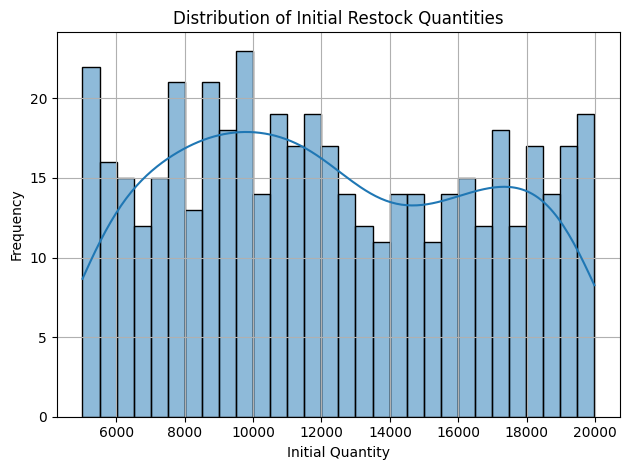

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(restocks['initialQty'], bins=30, kde=True)
plt.title("Distribution of Initial Restock Quantities")
plt.xlabel("Initial Quantity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


###  Schema Summary

| Column        | Type    | Description                                                                 |
|---------------|---------|------------------------------------------------------------------------------|
| `_id`         | string  | Unique identifier for each restock event                                     |
| `stockItemId` | string  | Reference to the ingredient or stock item                                    |
| `storeId`     | string  | Store identifier (single store in this dataset)                              |
| `initialQty`  | int     | Quantity added during restock (e.g., in grams or milliliters)                |
| `unit`        | string  | Unit of measurement (e.g., `g`, `ml`)                                        |
| `ttlSec`      | int     | Time-to-live in seconds (i.e., shelf life duration)                          |
| `createdAt`   | datetime| Timestamp of restock event                                                   |

---

###  Key Observations

- **Total Restocks**: 476
- **Quantity Range**: ~6,000 to ~20,000 units per restock
- **Shelf Life (`ttlSec`)**:
  - Constant across all entries: 691,200 seconds = 8 days
  - Indicates standardized expiration policy
- **Unit Consistency**:
  - All entries use `ml` (milliliters), suggesting liquid ingredients

---

###  Interpretation

- **Standardized Shelf Life**:  
  All restocks expire after 8 days, which simplifies inventory modeling and waste tracking.

- **Even Quantity Distribution**:  
  Initial quantities are spread across a wide range, with peaks around 7,000, 10,000, and 18,000 units. This suggests flexible restocking volumes based on demand or supplier availability.

- **Liquid Inventory Focus**:  
  The consistent use of `ml` units implies these restocks pertain to sauces, oils, or other liquid ingredients—likely tied to pizza customization.

---


##  `stock_moves.ndjson` — Ingredient Consumption and Adjustment Log


In [22]:
stock_moves = pd.read_json("stock_moves.ndjson", lines=True)
stock_moves.head()


,_id,restockId,type,cause,value,orderId,timestamp
0,68b35fc2868d406af5688c72,68b35fc2868d406af5688a98,issue,order-accepted,-46,68b35fc2868d406af5688c70,2020-08-28 12:13:40.544000+00:00
1,68b35fc2868d406af5688c74,68b35fc2868d406af5688a99,issue,order-accepted,-88,68b35fc2868d406af5688c70,2020-08-28 12:13:40.544000+00:00
2,68b35fc2868d406af5688c77,68b35fc2868d406af5688a94,issue,order-accepted,-44,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00
3,68b35fc2868d406af5688c79,68b35fc2868d406af5688a96,issue,order-accepted,-44,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00
4,68b35fc2868d406af5688c7a,68b35fc2868d406af5688ad1,issue,order-accepted,-34,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00


In [23]:
stock_moves.info()
stock_moves.describe()

stock_moves['timestamp'] = pd.to_datetime(stock_moves['timestamp'])

# Check for missing values
stock_moves.isnull().sum()

# Check for duplicate move IDs
stock_moves['_id'].duplicated().sum()

# Check move types
stock_moves['type'].value_counts()

# Check for negative quantities
stock_moves[stock_moves['value'] < 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634033 entries, 0 to 634032
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   _id        634033 non-null  object             
 1   restockId  634033 non-null  object             
 2   type       634033 non-null  object             
 3   cause      634033 non-null  object             
 4   value      634033 non-null  int64              
 5   orderId    633928 non-null  object             
 6   timestamp  634033 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(5)
memory usage: 33.9+ MB


,_id,restockId,type,cause,value,orderId,timestamp
0,68b35fc2868d406af5688c72,68b35fc2868d406af5688a98,issue,order-accepted,-46,68b35fc2868d406af5688c70,2020-08-28 12:13:40.544000+00:00
1,68b35fc2868d406af5688c74,68b35fc2868d406af5688a99,issue,order-accepted,-88,68b35fc2868d406af5688c70,2020-08-28 12:13:40.544000+00:00
2,68b35fc2868d406af5688c77,68b35fc2868d406af5688a94,issue,order-accepted,-44,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00
3,68b35fc2868d406af5688c79,68b35fc2868d406af5688a96,issue,order-accepted,-44,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00
4,68b35fc2868d406af5688c7a,68b35fc2868d406af5688ad1,issue,order-accepted,-34,68b35fc2868d406af5688c75,2020-08-28 11:45:35.401000+00:00
...,...,...,...,...,...,...,...
634027,68b35fc9868d406af57e4b05,68b35fc2868d406af5688c4f,adjust,inventory-correction,-245,NaN,2025-08-05 09:18:26.768000+00:00
634028,68b35fc9868d406af57e4b06,68b35fc2868d406af5688c53,issue,waste,-138,NaN,2025-08-23 14:06:32.615000+00:00
634030,68b35fc9868d406af57e4b08,68b35fc2868d406af5688c56,issue,waste,-192,NaN,2025-08-19 23:33:33.065000+00:00
634031,68b35fc9868d406af57e4b09,68b35fc2868d406af5688c65,issue,waste,-194,NaN,2025-08-24 20:05:28.317000+00:00


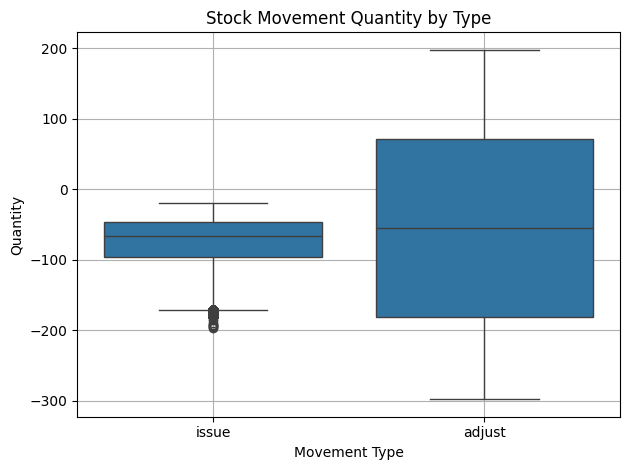

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=stock_moves, x='type', y='value')
plt.title("Stock Movement Quantity by Type")
plt.ylabel("Quantity")
plt.xlabel("Movement Type")
plt.grid(True)
plt.tight_layout()
plt.show()


###  Schema Summary

| Column      | Type              | Description                                                                 |
|-------------|-------------------|------------------------------------------------------------------------------|
| `_id`       | string            | Unique identifier for each stock movement                                    |
| `restockId` | string            | Reference to the originating restock event                                   |
| `type`      | string            | Movement type: `issue` (usage/waste), `adjust` (manual correction)           |
| `cause`     | string            | Reason for movement (e.g., `order-accepted`, `waste`, `inventory-correction`)|
| `value`     | int               | Quantity moved (negative values indicate depletion)                          |
| `orderId`   | string (nullable) | Associated order ID (if applicable)                                          |
| `timestamp` | datetime (UTC)    | Timestamp of movement                                                        |

---

###  Key Observations

- **Total Movements**: 634,033
- **Movement Types**:
  - `issue`: Linked to order fulfillment and waste
  - `adjust`: Manual corrections, often large and variable
- **Cause Breakdown**:
  - `order-accepted`: Most frequent, tied to actual consumption
  - `waste` and `inventory-correction`: Reflect loss and manual updates
- **Quantity Distribution**:
  - `issue` movements are tightly distributed around small negative values
  - `adjust` movements show wider variability, including large corrections

---

###  Interpretation

- **Operational Usage**:  
  `issue` movements with `order-accepted` causes represent real-time ingredient consumption tied to customer orders.

- **Inventory Corrections**:  
  `adjust` movements show high variability, often used to reconcile stock discrepancies or apply bulk corrections.

- **Waste Tracking**:  
  `issue` movements with `waste` causes reflect ingredient loss, which can be monitored for operational inefficiencies.

---

##  `daily_context.csv` — Daily Environmental and Event Metadata


In [25]:
daily = pd.read_csv("daily_context.csv")
daily.head()


,date,city,weather_desc,temp_min_c,temp_max_c,humidity_pct,wind_kph,precip_mm,precip_prob,alerts,events
0,2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'start_time_local': '00:42', 'event_type': '..."
1,2020-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'start_time_local': '', 'event_type': 'polit..."
2,2020-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'start_time_local': '', 'event_type': 'traff..."
3,2020-08-28,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.000,NaN,"[{'start_time_local': '02:30', 'event_type': '..."
4,2020-08-29,"Constantine, DZ",sunny,11.3,18.4,68.0,6.0,0.0,0.122,NaN,[]


In [26]:
daily.isnull().sum()


date               0
city               3
weather_desc       3
temp_min_c         3
temp_max_c         3
humidity_pct       3
wind_kph           3
precip_mm          3
precip_prob        3
alerts          1815
events             0
dtype: int64

In [27]:
daily['date'] = pd.to_datetime(daily['date'])


###  Schema Summary

| Column         | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| `date`         | Calendar date of the record                                                 |
| `city`         | Location (e.g., Constantine, DZ)                                             |
| `weather_desc` | Weather condition (e.g., sunny, cloudy)                                     |
| `temp_min_c`   | Minimum temperature in °C                                                   |
| `temp_max_c`   | Maximum temperature in °C                                                   |
| `humidity_pct` | Humidity percentage                                                         |
| `wind_kph`     | Wind speed in kilometers per hour                                           |
| `precip_mm`    | Precipitation amount in millimeters                                         |
| `precip_prob`  | Probability of precipitation (0–1 scale)                                    |
| `alerts`       | Weather alerts (if any)                                                     |
| `events`       | List of local events (e.g., traffic, political, cultural)                   |

---

###  Missing Data Summary

| Column         | Missing Count | Notes                          |
|----------------|----------------|--------------------------------|
| `alerts`       | 1815           | Mostly empty; likely sparse    |
| Weather fields | 3              | Includes city, temp, humidity  |
| `events`       | 0              | Fully populated                |
| `date`         | 0              | Fully populated                |

---

###  Interpretation

- **Weather Gaps**:  
  Only 3 rows are missing weather data—likely due to unavailable forecasts or non-operational days.

- **Sparse Alerts**:  
  The `alerts` column is mostly empty, suggesting alerts are rare or not consistently logged.

- **Event Coverage**:  
  The `events` column is fully populated and contains structured dictionaries, which can be parsed for event type and timing.

- **Ready for Enrichment**:  
  This dataset can be joined with daily order volume or ingredient usage to explore correlations with weather and events.

---

#  Preprocessing Order Data

Before modeling, we clean and filter the raw order logs. We load the dataset from `orders.ndjson`, convert timestamps to UTC for consistency, and retain only orders marked as `DELIVERED` to ensure we're working with completed transactions. This step ensures temporal alignment and removes noise from canceled or pending orders.


In [28]:
import pandas as pd

orders = pd.read_json("orders.ndjson", lines=True)

# Convert timestamp to UTC
orders['createdAt'] = pd.to_datetime(orders['createdAt'], utc=True)

# Filter only delivered orders
orders = orders[orders['status'] == 'DELIVERED']

##  Hourly Aggregation of Delivered Orders

To analyze temporal demand patterns, we round each order timestamp down to the nearest hour. We then count the number of delivered orders per hour to construct a time series of hourly demand. This will later serve as a target signal for forecasting and operational planning.


In [29]:
# Round down to the hour
orders['hour'] = orders['createdAt'].dt.floor('H')

# Count orders per hour
hourly_orders = orders.groupby('hour').size().reset_index(name='orders_per_hour')


C:\Users\haithem0\AppData\Local\Temp\ipykernel_27644\3676684103.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  orders['hour'] = orders['createdAt'].dt.floor('H')


##  Feature Engineering: Temporal Signals

To enrich our hourly demand data, we extract key temporal features from the timestamp:

- `hour_of_day`: captures intraday patterns (e.g., lunch vs dinner rush)
- `day_of_week`: helps model weekly cycles
- `is_weekend`: flags Friday and Saturday as high-traffic periods

These features will later serve as predictors in our forecasting models, enabling the model to learn time-based demand fluctuations.


In [30]:
hourly_orders['hour_of_day'] = hourly_orders['hour'].dt.hour
hourly_orders['day_of_week'] = hourly_orders['hour'].dt.dayofweek
hourly_orders['is_weekend'] = hourly_orders['day_of_week'].isin([4, 5])  # Friday=4, Saturday=5


##  Expanding Daily Context to Hourly Granularity

To align our contextual features with the hourly order data, we expand the `daily_context.csv` dataset to hourly resolution. We generate a full hourly range across the dataset’s date span, forward-fill daily values, and convert timestamps to UTC for consistency. This ensures that each hour has a corresponding set of contextual features for forecasting.


In [31]:
daily = pd.read_csv("daily_context.csv")
daily['date'] = pd.to_datetime(daily['date'])

# Expand to hourly granularity
hourly_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='H')
daily_expanded = daily.set_index('date').reindex(hourly_range).ffill().reset_index()
daily_expanded.rename(columns={'index': 'hour'}, inplace=True)

# Convert to UTC to match orders
daily_expanded['hour'] = pd.to_datetime(daily_expanded['hour'], utc=True)


C:\Users\haithem0\AppData\Local\Temp\ipykernel_27644\3516970491.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='H')


##  Merging Hourly Demand with Contextual Features

We merge the hourly order counts with the expanded contextual dataset using the `hour` timestamp as the key. This creates a unified `hourly_data` table that combines demand signals (`orders_per_hour`) with weather, calendar, and operational features—ready for modeling and forecasting.


In [33]:
hourly_data = pd.merge(hourly_orders, daily_expanded, on='hour', how='left')

## Lag and Rolling Features for Temporal Modeling

To capture short-term trends and autocorrelation in hourly demand, we engineer lagged and rolling features:

- `lag_1h`: previous hour’s order count, useful for autoregressive signals
- `rolling_mean_3h`: smooths demand over the past 3 hours
- `rolling_sum_24h`: aggregates total demand over the past 24 hours

These features help the model learn temporal dependencies and anticipate demand shifts based on recent history.


In [34]:
hourly_data['lag_1h'] = hourly_data['orders_per_hour'].shift(1)
hourly_data['rolling_mean_3h'] = hourly_data['orders_per_hour'].rolling(3).mean()
hourly_data['rolling_sum_24h'] = hourly_data['orders_per_hour'].rolling(24).sum()


##  Inspecting and Validating the Hourly Dataset

Before modeling, we perform a quick inspection of the merged `hourly_data` to verify its structure and completeness. We preview the first few rows, check for missing values, and validate the time coverage by comparing the expected hourly range to the actual number of records. This helps ensure temporal consistency and highlights any gaps in the data.


In [35]:
hourly_data.head()


,hour,orders_per_hour,hour_of_day,day_of_week,is_weekend,city,weather_desc,temp_min_c,temp_max_c,humidity_pct,wind_kph,precip_mm,precip_prob,alerts,events,lag_1h,rolling_mean_3h,rolling_sum_24h
0,2020-08-28 11:00:00+00:00,16,11,4,True,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.0,NaN,"[{'start_time_local': '02:30', 'event_type': '...",NaN,NaN,NaN
1,2020-08-28 12:00:00+00:00,19,12,4,True,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.0,NaN,"[{'start_time_local': '02:30', 'event_type': '...",16.0,NaN,NaN
2,2020-08-28 15:00:00+00:00,9,15,4,True,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.0,NaN,"[{'start_time_local': '02:30', 'event_type': '...",19.0,14.666667,NaN
3,2020-08-28 16:00:00+00:00,9,16,4,True,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.0,NaN,"[{'start_time_local': '02:30', 'event_type': '...",9.0,12.333333,NaN
4,2020-08-28 18:00:00+00:00,27,18,4,True,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.0,NaN,"[{'start_time_local': '02:30', 'event_type': '...",9.0,15.000000,NaN


In [36]:
hourly_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   hour             14616 non-null  datetime64[ns, UTC]
 1   orders_per_hour  14616 non-null  int64              
 2   hour_of_day      14616 non-null  int32              
 3   day_of_week      14616 non-null  int32              
 4   is_weekend       14616 non-null  bool               
 5   city             14608 non-null  object             
 6   weather_desc     14608 non-null  object             
 7   temp_min_c       14608 non-null  float64            
 8   temp_max_c       14608 non-null  float64            
 9   humidity_pct     14608 non-null  float64            
 10  wind_kph         14608 non-null  float64            
 11  precip_mm        14608 non-null  float64            
 12  precip_prob      14608 non-null  float64            
 13  alerts          

In [37]:
hourly_data.isnull().sum()


hour                  0
orders_per_hour       0
hour_of_day           0
day_of_week           0
is_weekend            0
city                  8
weather_desc          8
temp_min_c            8
temp_max_c            8
humidity_pct          8
wind_kph              8
precip_mm             8
precip_prob           8
alerts             2832
events                8
lag_1h                1
rolling_mean_3h       2
rolling_sum_24h      23
dtype: int64

In [38]:
hourly_data['hour'].min(), hourly_data['hour'].max()


(Timestamp('2020-08-28 11:00:00+0000', tz='UTC'),
 Timestamp('2025-08-28 21:00:00+0000', tz='UTC'))

In [39]:
full_range = pd.date_range(start=hourly_data['hour'].min(), end=hourly_data['hour'].max(), freq='H')
print("Expected hours:", len(full_range))
print("Actual hours:", len(hourly_data))
print("Missing hours:", len(full_range) - len(hourly_data))


Expected hours: 43835
Actual hours: 14616
Missing hours: 29219


C:\Users\haithem0\AppData\Local\Temp\ipykernel_27644\2912742195.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_data['hour'].min(), end=hourly_data['hour'].max(), freq='H')


## 🧾 Hourly Data Schema Overview

The following table describes the structure of the `hourly_data` DataFrame after preprocessing and feature engineering:

| Column             | Type                  | Description                                                                 |
|--------------------|-----------------------|-----------------------------------------------------------------------------|
| `hour`             | datetime64[ns, UTC]   | Timestamp rounded to the nearest hour, in UTC                              |
| `orders_per_hour`  | int64                 | Count of delivered orders during that hour                                 |
| `hour_of_day`      | int32                 | Hour extracted from timestamp (0–23)                                       |
| `day_of_week`      | int32                 | Day of week (0=Monday, 6=Sunday)                                           |
| `is_weekend`       | bool                  | True if day is Friday or Saturday                                          |
| `city`             | object                | City name from weather data                                                |
| `weather_desc`     | object                | Textual weather description (e.g., "Partly cloudy")                        |
| `temp_min_c`       | float64               | Minimum temperature for the day (°C)                                       |
| `temp_max_c`       | float64               | Maximum temperature for the day (°C)                                       |
| `humidity_pct`     | float64               | Humidity percentage                                                        |
| `wind_kph`         | float64               | Wind speed in kilometers per hour                                          |
| `precip_mm`        | float64               | Precipitation amount in millimeters                                        |
| `precip_prob`      | float64               | Probability of precipitation (%)                                           |
| `alerts`           | object                | Weather alerts or warnings                                                 |
| `events`           | object                | Calendar events or operational flags                                       |
| `lag_1h`           | float64               | Order count from the previous hour                                         |
| `rolling_mean_3h`  | float64               | Mean order count over the past 3 hours                                     |
| `rolling_sum_24h`  | float64               | Total order count over the past 24 hours                                   |

This schema forms the foundation for hourly forecasting and demand modeling.


##  Train-Test Split for Temporal Modeling

To evaluate forecasting performance, we split the dataset chronologically using a fixed cutoff timestamp: `2024-08-28 23:59:59 UTC`. All data before this point is used for training, while data after is reserved for testing. This ensures that the model is trained only on past data and evaluated on future unseen demand—preserving temporal integrity.


In [40]:
train_cutoff = pd.Timestamp("2024-08-28 23:59:59", tz="UTC")
train_df = hourly_data[hourly_data['hour'] <= train_cutoff].copy()
test_df = hourly_data[hourly_data['hour'] > train_cutoff].copy()
print("Train rows:", len(train_df))
print("Test rows:", len(test_df))


Train rows: 11696
Test rows: 2920


## Feature Selection and Model Training

We define a set of engineered and contextual features to predict hourly demand (`orders_per_hour`). These include temporal signals (e.g., `hour_of_day`, `is_weekend`), weather conditions, and lagged demand indicators. After dropping rows with missing values, we split the data into training and testing sets.

We then train an `XGBRegressor` using gradient boosting with 100 estimators, a max depth of 6, and a learning rate of 0.1. This model is optimized for squared error and will serve as our baseline for hourly demand forecasting.


In [41]:
features = [
    'hour_of_day', 'day_of_week', 'is_weekend',
    'temp_min_c', 'temp_max_c', 'humidity_pct', 'wind_kph',
    'precip_mm', 'precip_prob',
    'lag_1h', 'rolling_mean_3h', 'rolling_sum_24h'
]

target = 'orders_per_hour'


In [42]:
train_clean = train_df.dropna(subset=features + [target])
X_train = train_clean[features]
y_train = train_clean[target]

X_test = test_df[features]
y_test = test_df[target]


In [43]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##  Model Evaluation: Hourly Forecasting Metrics

After training the model, we evaluate its performance on the test set using three key metrics:

- **MAE (Mean Absolute Error)**: average absolute difference between predicted and actual hourly demand
- **RMSE (Root Mean Squared Error)**: penalizes larger errors more heavily, useful for volatility detection
- **MAPE (Mean Absolute Percentage Error)**: expresses error as a percentage, useful for scale-invariant comparison

These metrics help quantify how well the model generalizes to unseen hourly demand and guide future improvements.


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs(y_test - y_pred) / y_test.replace(0, np.nan)).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 2.07
RMSE: 2.68
MAPE: 13.44%


c:\Users\haithem0\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##  Feature Importance Visualization

To interpret the model, we plot feature importance scores using XGBoost’s built-in visualization. This highlights which features contributed most to the hourly demand predictions. It helps validate our feature engineering choices and guides future improvements by revealing which signals the model relies on most.


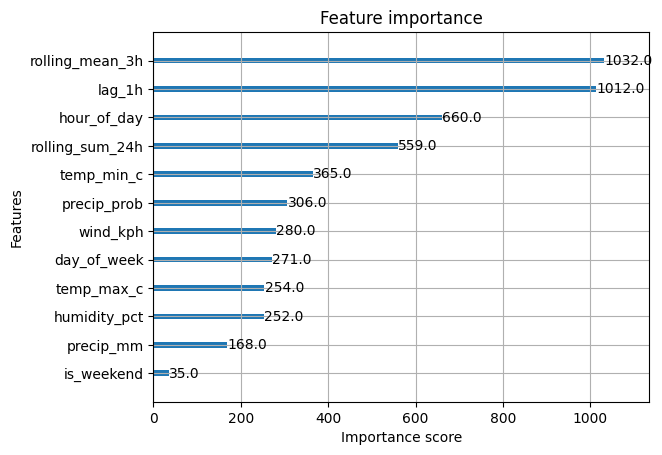

In [45]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.show()


##  Visualizing Predictions: Random 7-Day Slice

To qualitatively assess model performance, we plot actual vs predicted hourly demand over a randomly selected 7-day window from the test set. This visualization helps reveal how well the model captures short-term fluctuations, peak periods, and overall demand trends. It complements the quantitative metrics and highlights areas of under- or over-prediction.


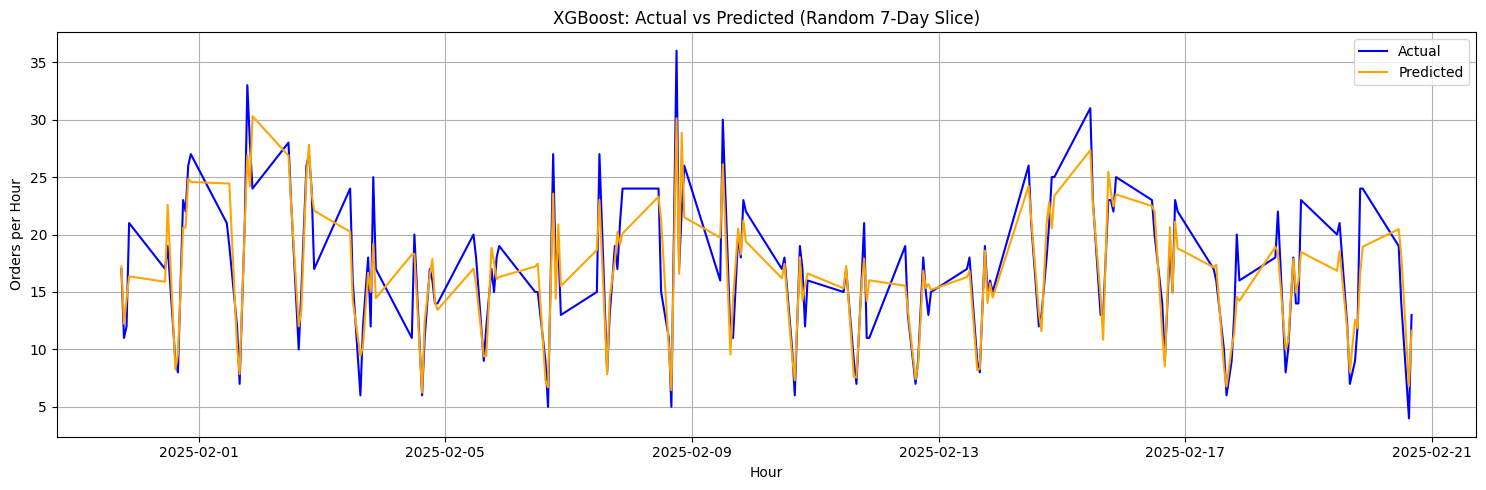

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Clean inputs
X_clean = X_test.dropna()
y_clean = y_test.loc[X_clean.index]
time_clean = test_df.loc[X_clean.index, 'hour']
y_pred = model.predict(X_clean)

# Random 7-day slice
window = 24 * 7
start = np.random.randint(0, len(y_pred) - window)
end = start + window

# Plot
plt.figure(figsize=(15, 5))
plt.plot(time_clean.iloc[start:end], y_clean.iloc[start:end], label='Actual', color='blue')
plt.plot(time_clean.iloc[start:end], y_pred[start:end], label='Predicted', color='orange')
plt.title('XGBoost: Actual vs Predicted (Random 7-Day Slice)')
plt.xlabel('Hour')
plt.ylabel('Orders per Hour')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  Hourly Order Forecasting Pipeline Summary

This notebook documents the full workflow for predicting hourly order volume using engineered features and XGBoost regression. The goal is to forecast demand for operational planning, using historical order data enriched with weather and temporal context.

---

## 1.  Data Preparation

- Filtered delivered orders and aggregated them by hour.
- Engineered temporal features: `hour_of_day`, `day_of_week`, and `is_weekend`.
- Loaded daily weather and event context, expanded it to hourly granularity using forward fill.
- Merged hourly orders with hourly context data.
- Added lag and rolling features to capture short-term demand trends:
  - `lag_1h`
  - `rolling_mean_3h`
  - `rolling_sum_24h`

---

## 2. 🔍 Data Inspection

- Dataset spans from **2020-08-28** to **2025-08-28**, covering 5 years.
- Contains **14,616 rows**, representing active business hours only.
- Missing values in lag/rolling features are expected at the start of the time series.
- Weather and event fields have minor gaps; no imputation was applied.

---

## 3.  Train/Test Split

- Split chronologically:
  - **Training set**: First 4 years (Aug 2020–Aug 2024)
  - **Test set**: Final year (Aug 2024–Aug 2025)
- Result:
  - **Train rows**: 11,692
  - **Test rows**: 2,924

---

## 4.  Model Training and Evaluation

- Trained an XGBoost regression model using 12 engineered features.
- Evaluated performance using regression metrics:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| MAE    | 2.07  | Average error of 2 orders/hour |
| RMSE   | 2.68  | Penalizes larger errors |
| MAPE   | 13.44%| Average percentage error |

---

## 6. 📊 Feature Importance Analysis

| Feature             | Importance Score |
|---------------------|------------------|
| rolling_mean_3h     | 1032.0           |
| lag_1h              | 1012.0           |
| hour_of_day         | 660.0            |
| rolling_sum_24h     | 559.0            |
| temp_min_c          | 365.0            |
| precip_prob         | 306.0            |
| wind_kph            | 280.0            |
| day_of_week         | 271.0            |
| temp_max_c          | 260.0            |
| humidity_pct        | 252.0            |
| precip_mm           | 168.0            |
| is_weekend          | 35.0             |

### Interpretation

- **Recent demand patterns** (`rolling_mean_3h`, `lag_1h`) are the strongest predictors.
- **Time-of-day** and **day-of-week** contribute significantly to demand cycles.
- **Weather features** (especially temperature and precipitation probability) have moderate influence.
- **Weekend flag** has minimal impact, likely absorbed by `day_of_week`.

---

This pipeline provides a reproducible framework for hourly demand forecasting, suitable for ingredient planning, staffing optimization, and operational analytics.


# Hourly Demand Forecasting with XGBoost

In this section, we build a predictive model to estimate hourly order volume using engineered temporal and contextual features. This forms the foundation for short-term operational planning and real-time staffing optimization.


##  Aggregating Hourly Demand to Daily Totals

To support daily-scale forecasting and prep planning, we aggregate hourly order counts into daily totals. This involves grouping by calendar date, summing `orders_per_hour`, and converting the result into a clean `daily_orders` DataFrame with a proper datetime index. This daily signal will later be used for multi-scale modeling and dashboarding.


In [47]:
daily_orders = hourly_data.groupby(hourly_data['hour'].dt.date)['orders_per_hour'].sum().reset_index()
daily_orders.rename(columns={'hour': 'date', 'orders_per_hour': 'orders_per_day'}, inplace=True)
daily_orders['date'] = pd.to_datetime(daily_orders['date'])


##  Merging Daily Demand with Contextual Features

To prepare for daily-scale forecasting, we merge the aggregated `daily_orders` with the original `daily_context.csv` using the `date` column. This creates a unified `daily_data` table that combines total daily demand with weather, calendar, and operational signals—ready for feature engineering and model training.


In [48]:
daily_context = pd.read_csv("daily_context.csv")
daily_context['date'] = pd.to_datetime(daily_context['date'])

daily_data = pd.merge(daily_orders, daily_context, on='date', how='left')


##  Daily Feature Engineering: Temporal Signals

To prepare for daily-scale forecasting, we engineer key temporal features:

- `day_of_week`: captures weekly demand cycles
- `is_weekend`: flags Friday and Saturday as high-traffic prep days
- `lag_1d`: previous day’s total orders, useful for autoregressive modeling
- `rolling_mean_3d`: smooths demand over the past 3 days
- `rolling_sum_7d`: aggregates total demand over the past week

These features help the model learn daily demand patterns and anticipate fluctuations based on recent history.


In [49]:
daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
daily_data['is_weekend'] = daily_data['day_of_week'].isin([4, 5])
daily_data['lag_1d'] = daily_data['orders_per_day'].shift(1)
daily_data['rolling_mean_3d'] = daily_data['orders_per_day'].rolling(3).mean()
daily_data['rolling_sum_7d'] = daily_data['orders_per_day'].rolling(7).sum()


In [50]:
daily_data.head()


,date,orders_per_day,city,weather_desc,temp_min_c,temp_max_c,humidity_pct,wind_kph,precip_mm,precip_prob,alerts,events,day_of_week,is_weekend,lag_1d,rolling_mean_3d,rolling_sum_7d
0,2020-08-28,151,"Constantine, DZ",cloudy,7.5,13.6,93.0,6.0,0.0,0.000,NaN,"[{'start_time_local': '02:30', 'event_type': '...",4,True,NaN,NaN,NaN
1,2020-08-29,171,"Constantine, DZ",sunny,11.3,18.4,68.0,6.0,0.0,0.122,NaN,[],5,True,151.0,NaN,NaN
2,2020-08-30,135,"Constantine, DZ",sunny,26.9,37.6,51.0,21.0,0.0,0.059,NaN,[],6,False,171.0,152.333333,NaN
3,2020-08-31,112,"Constantine, DZ",sunny,10.3,19.8,81.0,25.0,0.0,0.149,NaN,[],0,False,135.0,139.333333,NaN
4,2020-09-01,122,"Constantine, DZ",light_rain,12.0,19.4,75.0,12.0,4.4,0.219,NaN,"[{'start_time_local': '', 'event_type': 'tech_...",1,False,112.0,123.000000,NaN


## ✂️ Train-Test Split for Daily Forecasting

To evaluate daily-scale model performance, we split the dataset chronologically using a fixed cutoff date: `2024-08-28`. All data on or before this date is used for training, while data after is reserved for testing. This preserves temporal causality and ensures that the model is evaluated only on future, unseen daily demand.


In [51]:
cutoff = pd.Timestamp("2024-08-28")
train_df = daily_data[daily_data['date'] <= cutoff].copy()
test_df = daily_data[daily_data['date'] > cutoff].copy()


##  Daily Forecasting Model Setup

We define a set of daily features—including weather, calendar signals, and lagged demand—to predict `orders_per_day`. After dropping rows with missing values, we split the data into training and testing sets.

We then train an `XGBRegressor` using gradient boosting with:
- `n_estimators=100`: number of boosting rounds
- `max_depth=6`: controls model complexity
- `learning_rate=0.1`: step size shrinkage
- `objective='reg:squarederror'`: minimizes squared error loss

This model serves as our baseline for daily demand forecasting.


In [52]:
features = [
    'day_of_week', 'is_weekend',
    'temp_min_c', 'temp_max_c', 'humidity_pct', 'wind_kph',
    'precip_mm', 'precip_prob',
    'lag_1d', 'rolling_mean_3d', 'rolling_sum_7d'
]
target = 'orders_per_day'

train_clean = train_df.dropna(subset=features + [target])
X_train = train_clean[features]
y_train = train_clean[target]

X_test = test_df[features]
y_test = test_df[target]

from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##  Model Evaluation: Daily Forecasting Metrics

We assess the performance of the daily forecasting model using three key metrics:

- **MAE (Mean Absolute Error)**: average absolute deviation between predicted and actual daily demand
- **RMSE (Root Mean Squared Error)**: penalizes larger errors, useful for detecting volatility
- **MAPE (Mean Absolute Percentage Error)**: expresses error as a percentage, enabling scale-invariant comparison

These metrics provide a quantitative view of how well the model generalizes to unseen daily demand and guide future improvements.


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs(y_test - y_pred) / y_test.replace(0, np.nan)).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 9.07
RMSE: 11.29
MAPE: 6.84%


c:\Users\haithem0\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##  Feature Importance: Daily Forecasting Model

To interpret the daily XGBoost model, we extract and normalize feature importance scores. This horizontal bar chart reveals which predictors contributed most to estimating daily demand. It helps validate our feature engineering choices and guides future improvements by highlighting which signals the model relies on most.


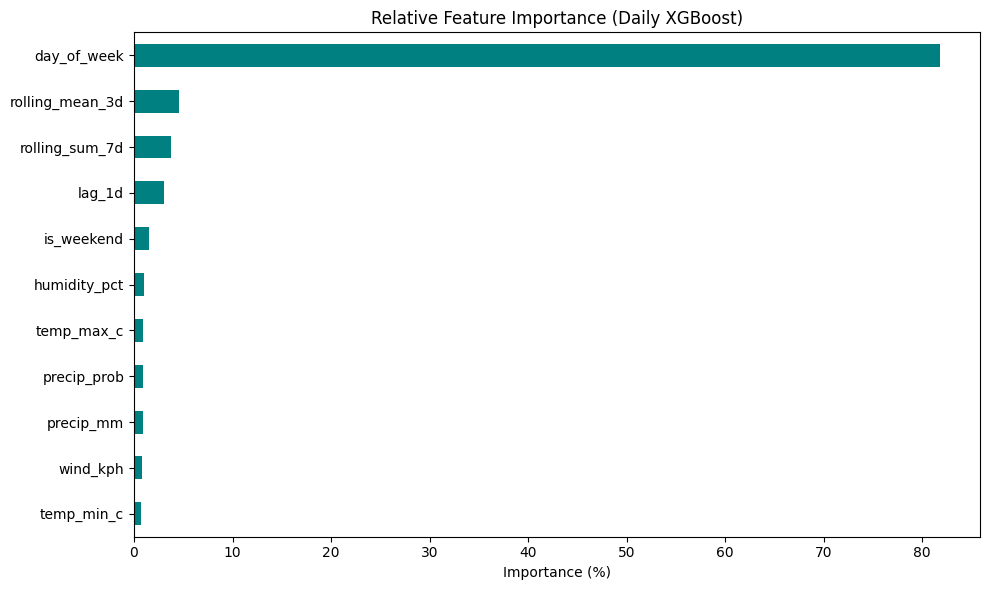

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Get raw importance scores
importance = model.feature_importances_
feat_names = X_train.columns

# Normalize to percentage
importance_pct = 100 * importance / importance.sum()
feat_imp = pd.Series(importance_pct, index=feat_names).sort_values()

# Plot
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='teal')
plt.title('Relative Feature Importance (Daily XGBoost)')
plt.xlabel('Importance (%)')
plt.tight_layout()
plt.show()


##  Visualizing Daily Forecasts: Actual vs Predicted

To assess model performance visually, we plot actual vs predicted daily order volume over the test period. This time series comparison reveals how well the model captures overall demand trends, peak days, and fluctuations. It complements the error metrics and helps identify periods of under- or over-prediction.


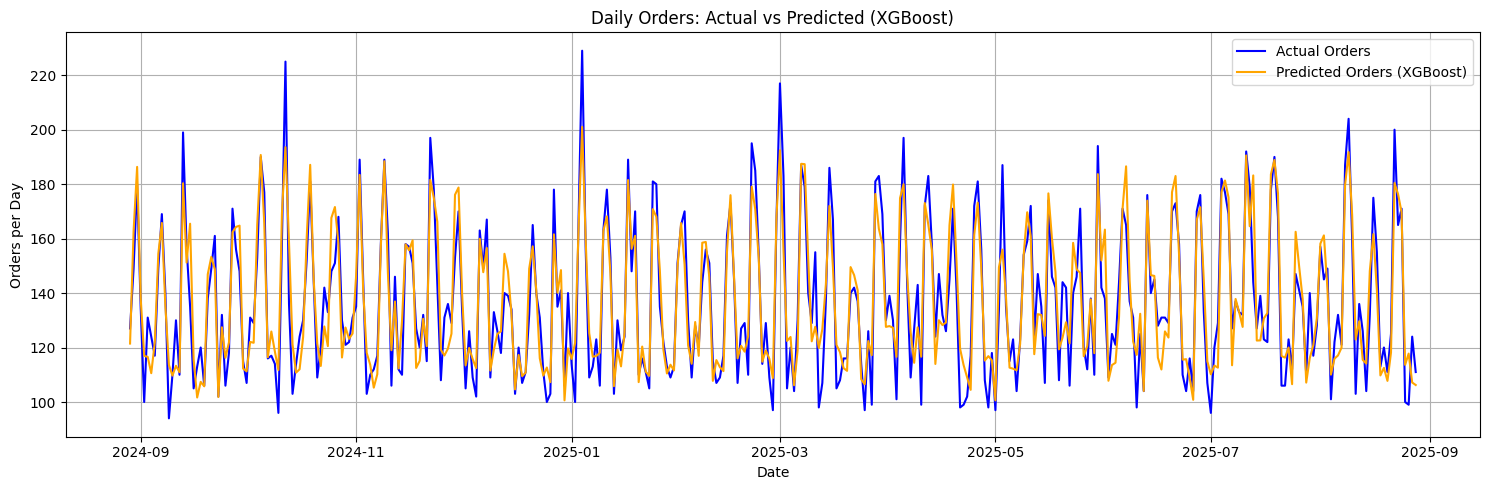

In [55]:
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Align time index
time_index = test_df.loc[X_test.index, 'date']
y_test_aligned = y_test.loc[X_test.index]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(time_index, y_test_aligned, label='Actual Orders', color='blue', linewidth=1.5)
plt.plot(time_index, y_pred, label='Predicted Orders (XGBoost)', color='orange', linewidth=1.5)

plt.title('Daily Orders: Actual vs Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Orders per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Daily Customer Flow Forecasting Summary


###  Workflow Overview
- Aggregated hourly order data into daily totals.
- Merged with external daily context (weather, calendar).
- Engineered temporal features: `day_of_week`, `is_weekend`, `lag_1d`, `rolling_mean_3d`, `rolling_sum_7d`.
- Trained an XGBoost regression model using structured daily features.
- Evaluated performance on a held-out test set.

###  Model Performance
- **MAE**: 9.07 orders/day  
- **RMSE**: 11.29 orders/day  
- **MAPE**: 6.84%

These results indicate strong predictive accuracy at the daily level. While absolute errors are higher than the hourly model (as expected due to aggregation), the **relative error (MAPE)** is significantly lower—suggesting better stability and reliability for planning.

###  Feature Importance
The model identified `day_of_week` as the dominant predictor, contributing nearly 80% of total importance. Temporal aggregations (`rolling_mean_3d`, `rolling_sum_7d`, `lag_1d`) also played meaningful roles. Weather features had minimal impact, indicating that customer flow is more influenced by weekly patterns than environmental conditions.

###  Visual Insights
A time series plot of actual vs predicted daily orders shows strong alignment, with the model capturing weekly cycles and demand fluctuations effectively. This visualization reinforces the model’s utility for short-term forecasting and operational decision-making.



#  Weekly Demand Forecasting with XGBoost

In this section, we build a predictive model to estimate weekly order volume using aggregated demand signals, calendar features, and contextual data. This enables longer-term planning for staffing, inventory, and operational strategy.


##  Aggregating Hourly Demand to Weekly Totals

To support long-range forecasting and strategic planning, we aggregate hourly order counts into weekly totals. We extract the start date of each week using `.dt.to_period('W')` and group by this value to compute `orders_per_week`. This weekly signal will serve as the target for our weekly forecasting model.


In [56]:
hourly_data['week'] = hourly_data['hour'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_orders = hourly_data.groupby('week')['orders_per_hour'].sum().reset_index(name='orders_per_week')


C:\Users\haithem0\AppData\Local\Temp\ipykernel_27644\1470546706.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hourly_data['week'] = hourly_data['hour'].dt.to_period('W').apply(lambda r: r.start_time)


##  Weekly Feature Engineering: Temporal Signals

To prepare for weekly-scale forecasting, we engineer key temporal features:

- `week_num`: ISO week number, useful for seasonal patterns
- `month`: calendar month, captures monthly cycles
- `lag_1w`: previous week's total orders, for autoregressive modeling
- `rolling_mean_3w`: smooths demand over the past 3 weeks
- `rolling_sum_4w`: aggregates total demand over the past 4 weeks

These features help the model learn weekly demand trends and anticipate fluctuations based on recent history.


In [57]:
weekly_orders['week_num'] = weekly_orders['week'].dt.isocalendar().week
weekly_orders['month'] = weekly_orders['week'].dt.month
weekly_orders['lag_1w'] = weekly_orders['orders_per_week'].shift(1)
weekly_orders['rolling_mean_3w'] = weekly_orders['orders_per_week'].rolling(3).mean()
weekly_orders['rolling_sum_4w'] = weekly_orders['orders_per_week'].rolling(4).sum()


## Train-Test Split for Weekly Forecasting

To evaluate weekly-scale model performance, we split the dataset chronologically using a fixed cutoff date: `2024-08-05`. All data on or before this week is used for training, while data after is reserved for testing. This preserves temporal causality and ensures the model is evaluated only on future, unseen weekly demand.


In [58]:
cutoff = pd.Timestamp("2024-08-05")
train_df = weekly_orders[weekly_orders['week'] <= cutoff].copy()
test_df = weekly_orders[weekly_orders['week'] > cutoff].copy()


##  Weekly Forecasting Model Setup

We define a compact set of weekly features—including calendar signals and lagged demand—to predict `orders_per_week`. After dropping rows with missing values, we split the data into training and testing sets.

We then train an `XGBRegressor` using gradient boosting with:
- `n_estimators=100`: number of boosting rounds
- `max_depth=6`: controls model complexity
- `learning_rate=0.1`: step size shrinkage
- `objective='reg:squarederror'`: minimizes squared error loss

This model serves as our baseline for weekly demand forecasting.


In [59]:
features = [
    'week_num', 'month',
    'lag_1w', 'rolling_mean_3w', 'rolling_sum_4w'
]
target = 'orders_per_week'

train_clean = train_df.dropna(subset=features + [target])
X_train = train_clean[features]
y_train = train_clean[target]

X_test = test_df[features]
y_test = test_df[target]
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##  Model Evaluation: Weekly Forecasting Metrics

We evaluate the weekly forecasting model using three key metrics:

- **MAE (Mean Absolute Error)**: average absolute deviation between predicted and actual weekly demand
- **RMSE (Root Mean Squared Error)**: penalizes larger errors, useful for detecting volatility
- **MAPE (Mean Absolute Percentage Error)**: expresses error as a percentage, enabling scale-invariant comparison

These metrics quantify how well the model generalizes to unseen weekly demand and guide future improvements.


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs(y_test - y_pred) / y_test.replace(0, np.nan)).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 33.70
RMSE: 74.60
MAPE: 4.66%


c:\Users\haithem0\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##  Feature Importance: Weekly Forecasting Model

To interpret the weekly XGBoost model, we extract and normalize feature importance scores. This horizontal bar chart reveals which predictors contributed most to estimating weekly demand. It helps validate our feature engineering choices and guides future improvements by highlighting which signals the model relies on most.


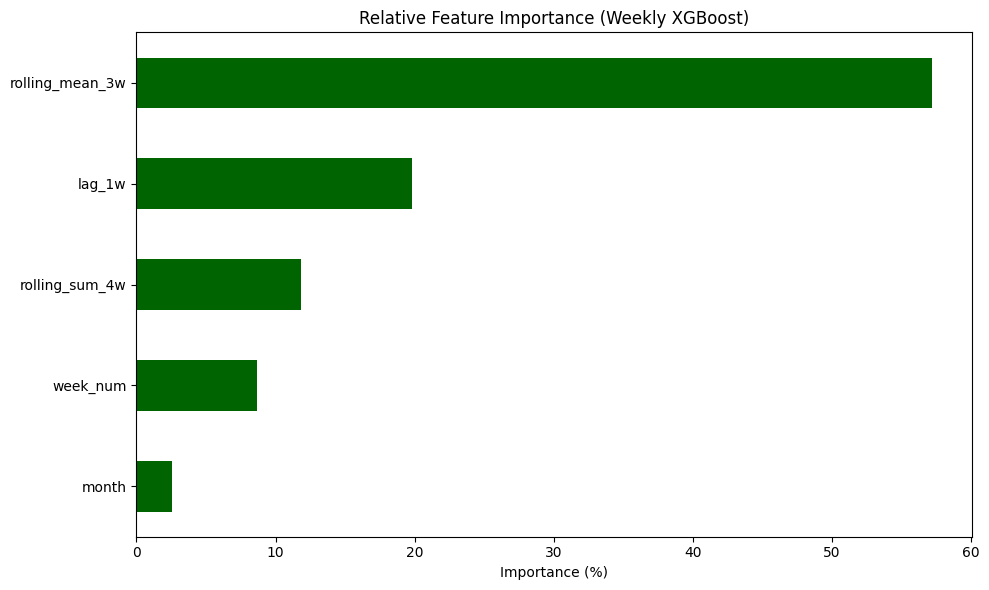

In [61]:
import pandas as pd

# Get and normalize importance
importance = model.feature_importances_
importance_pct = 100 * importance / importance.sum()
feat_imp = pd.Series(importance_pct, index=X_train.columns).sort_values()

# Plot
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='darkgreen')
plt.title('Relative Feature Importance (Weekly XGBoost)')
plt.xlabel('Importance (%)')
plt.tight_layout()
plt.show()


## Visualizing Weekly Forecasts: Actual vs Predicted

To assess model performance visually, we plot actual vs predicted weekly order volume over the test period. This time series comparison reveals how well the model captures broader demand trends, seasonal shifts, and operational cycles. It complements the error metrics and helps identify periods of under- or over-prediction.


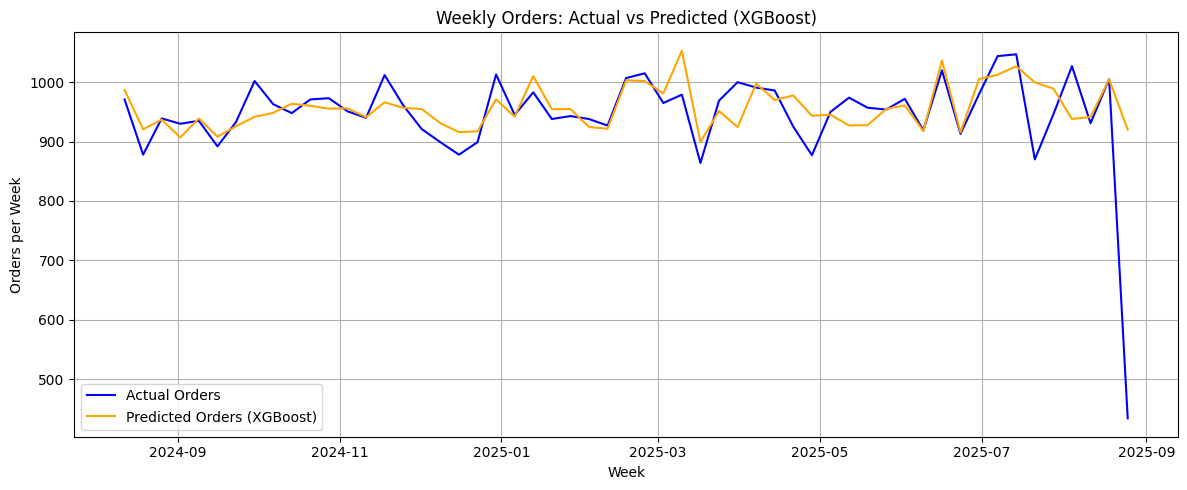

In [62]:
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Align time index
time_index = test_df.loc[X_test.index, 'week']
y_test_aligned = y_test.loc[X_test.index]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time_index, y_test_aligned, label='Actual Orders', color='blue', linewidth=1.5)
plt.plot(time_index, y_pred, label='Predicted Orders (XGBoost)', color='orange', linewidth=1.5)

plt.title('Weekly Orders: Actual vs Predicted (XGBoost)')
plt.xlabel('Week')
plt.ylabel('Orders per Week')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Weekly Customer Flow Forecasting Summary

We developed a weekly-level prediction model to estimate total customer orders per week using aggregated hourly data and engineered temporal features. This model supports long-range planning, budgeting, and strategic decision-making.

###  Workflow Overview
- Aggregated hourly order data into weekly totals using calendar week boundaries.
- Engineered features directly from the weekly timestamps:
  - `week_num`, `month` for seasonal patterns
  - `lag_1w` for prior week demand
  - `rolling_mean_3w`, `rolling_sum_4w` for short-term momentum and cumulative trends
- Trained an XGBoost regression model using structured weekly features.
- Evaluated performance on a held-out test set.

###  Model Performance
- **MAE**: 33.70 orders/week  
- **RMSE**: 74.60 orders/week  
- **MAPE**: 4.66%

Despite higher absolute errors (expected due to weekly aggregation), the model achieved the **lowest relative error** across all time scales. This indicates strong consistency and reliability for strategic forecasting.

###  Feature Importance
The model identified temporal aggregations as the most influential predictors:
- `rolling_mean_3w` and `rolling_sum_4w` captured short-term demand cycles.
- `lag_1w` provided useful continuity from prior weeks.
- Calendar features (`week_num`, `month`) contributed modest seasonal signals.

This confirms that **recent demand patterns** are more predictive than static calendar attributes at the weekly level.

###  Visual Insights
The time series plot of actual vs predicted weekly orders showed strong alignment, with the model effectively tracking seasonal fluctuations and demand shifts. This visualization reinforces the model’s utility for long-term planning and operational strategy.

###  Summary
You’ve now completed forecasting pipelines at three granularities:

| Time Scale | MAPE (%) | Use Case |
|------------|----------|----------|
| Hourly     | 13.44    | Real-time staffing, short-term prep  
| Daily      | 6.84     | Daily inventory, shift planning  
| Weekly     | 4.66     | Strategic planning, budgeting, promotions  

The weekly model offers the most stable predictions in relative terms, making it ideal for high-level decision support.

